
# Visualization of CBO
Adapted from [Gaussian Processes regression: basic introductory example](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-noisy-targets-py)



In [1]:
# Author: Vincent Dubourg <vincent.dubourg@gmail.com>
#         Jake Vanderplas <vanderplas@astro.washington.edu>
#         Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>
#         Guillaume Lemaitre <g.lemaitre58@gmail.com>
# License: BSD 3 clause

## Objective




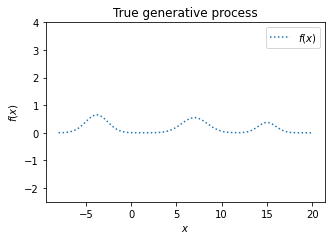

In [2]:
import numpy as np
import matplotlib.pyplot as plt

x_left = -8
x_right = 20
X = np.linspace(start=x_left, stop=x_right, num=1_000).reshape(-1, 1)
f = lambda X: (2.6 * np.exp(-(X+3.8)**2/3) + 2.2 * np.exp(-(X-7)**2/4) + 1.5 * np.exp(-(X-15)**2/2))/4
y = np.squeeze(f(X))


fig = plt.figure(figsize=[5, 3.3])
plt.plot(X, y, label=r"$f(x)$", linestyle="dotted")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.ylim(-2.5, 4)
_ = plt.title("True generative process")

0.325**2 * RBF(length_scale=2.88)


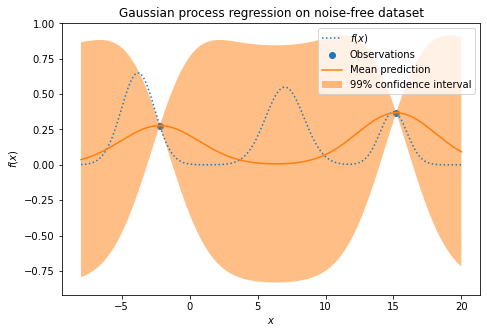

In [3]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e0, 3))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)


X_train = np.array([ -2.2, 15.2])[:,np.newaxis]
y_train = f(X_train)

gaussian_process.fit(X_train, y_train)
print(gaussian_process.kernel_)

# plot UCB, LCB and Pred
mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)
std_prediction = std_prediction.squeeze()
mean_prediction = mean_prediction.squeeze()

lcb, ucb = mean_prediction - 2.576 * std_prediction, mean_prediction + 2.576 * std_prediction,

fig = plt.figure(figsize=[7.5, 5])
plt.plot(X, y, label=r"$f(x)$", linestyle="dotted")
plt.scatter(X_train, y_train, label="Observations")
plt.plot(X, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    lcb, ucb,
    alpha=0.5,
    label=r"99% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression on noise-free dataset")

## Contraints

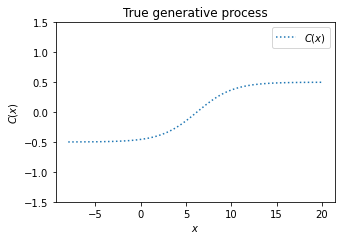

In [4]:
import numpy as np
import matplotlib.pyplot as plt

c = lambda X: ((1/(1 + np.exp(-(X-6.2)/2))) - .5)/1.0
yc = np.squeeze(c(X))


fig = plt.figure(figsize=[5, 3.3])
plt.plot(X, yc, label=r"$C(x)$", linestyle="dotted")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$C(x)$")
plt.ylim(-1.5, 1.5)
_ = plt.title("True generative process")

0.488**2 * RBF(length_scale=5)


/opt/homebrew/Caskroom/miniforge/base/envs/CBO/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 5.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


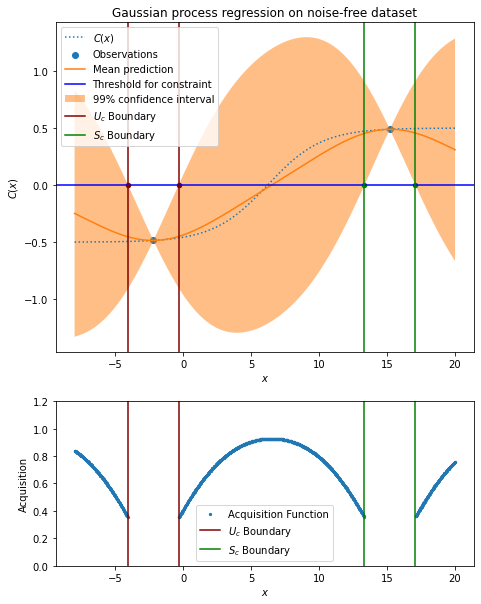

In [5]:
c_train = c(X_train)

kernel_c = 1 * RBF(length_scale=1.0, length_scale_bounds=(5, 1e1))
gaussian_process_c = GaussianProcessRegressor(kernel=kernel_c, n_restarts_optimizer=9)
gaussian_process_c.fit(X_train, c_train)
print(gaussian_process_c.kernel_)

# plot UCB, LCB and Pred
mean_prediction_c, std_prediction_c = gaussian_process_c.predict(X, return_std=True)
std_prediction_c = std_prediction_c.squeeze()
mean_prediction_c = mean_prediction_c.squeeze()

ucb_c, lcb_c = mean_prediction_c + 2.576 * std_prediction_c, mean_prediction_c - 2.576 * std_prediction_c, 

fig, axes = plt.subplots(2, 1, figsize=[7.5, 10], gridspec_kw={'height_ratios': [2, 1]})

# original GP
plt.subplot(2,1,1)
plt.plot(X, yc, label=r"$C(x)$", linestyle="dotted")
plt.scatter(X_train, c_train, label="Observations")
plt.plot(X, mean_prediction_c, label="Mean prediction")
plt.axhline(y = 0, color = 'blue', linestyle = '-', label='Threshold for constraint')
plt.fill_between(
    X.ravel(),
    lcb_c,
    ucb_c,
    alpha=0.5,
    label=r"99% confidence interval",
)

ucb_c_idx = np.argsort(np.abs(ucb_c))[:2]
lcb_c_idx = np.argsort(np.abs(lcb_c))[:2]

plt.axvline(x = X[ucb_c_idx[0]], color = 'maroon')
plt.scatter(X[ucb_c_idx[0]], 0, s=20, color = 'maroon',)
plt.axvline(x = X[ucb_c_idx[1]], color = 'maroon', label=r'$U_c$ Boundary')
plt.scatter(X[ucb_c_idx[1]], 0, s=20, color = 'maroon')

plt.axvline(x = X[lcb_c_idx[0]], color = 'green')
plt.scatter(X[lcb_c_idx[0]], 0, s=20, color = 'green',)
plt.axvline(x = X[lcb_c_idx[1]], color = 'green',  label=r'$S_c$ Boundary')
plt.scatter(X[lcb_c_idx[1]], 0, s=20, color = 'green')

plt.legend()
plt.xlabel("$x$")
plt.ylabel("$C(x)$")
_ = plt.title("Gaussian process regression on noise-free dataset")

# acquisition function
acq_c = 2 * std_prediction_c
acq_c_filter_ucb = np.logical_or(X.squeeze() < np.min(X[ucb_c_idx]), X.squeeze() >  np.max(X[ucb_c_idx]))
acq_c_filter_lcb = np.logical_or(X.squeeze() <  np.min(X[lcb_c_idx]), X.squeeze() >  np.max(X[lcb_c_idx]))
acq_c_filter = np.logical_and(acq_c_filter_ucb, acq_c_filter_lcb)
plt.subplot(2,1,2,)
plt.scatter(X[acq_c_filter], acq_c[acq_c_filter], label="Acquisition Function", s=5)
acq_c_argmax = acq_c.argmax()


plt.ylim(0, 1.2)
plt.xlabel("$x$")
plt.ylabel("Acquisition")
plt.axvline(x = X[ucb_c_idx[0]], color = 'maroon')
plt.axvline(x = X[ucb_c_idx[1]], color = 'maroon', label=r'$U_c$ Boundary')
plt.axvline(x = X[lcb_c_idx[0]], color = 'green')
plt.axvline(x = X[lcb_c_idx[1]], color = 'green', label=r'$S_c$ Boundary')
plt.legend()
plt.savefig('EG1D_C.png')



## Updated Obj

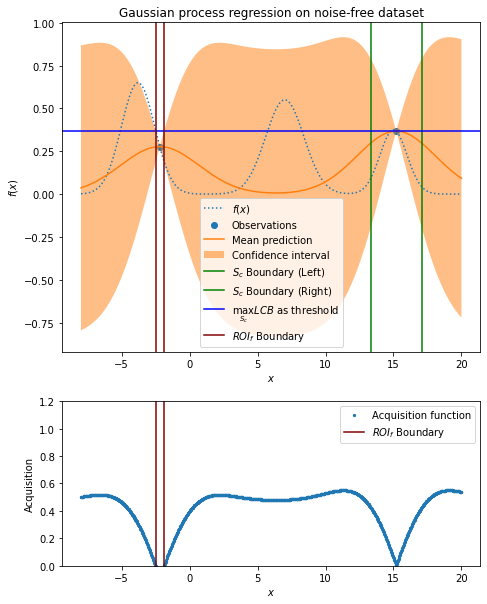

In [6]:
# plot UCB, LCB and Pred
mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)
std_prediction = std_prediction.squeeze()
mean_prediction = mean_prediction.squeeze()

# fig = plt.figure(figsize=[7.5, 5])
fig, axes = plt.subplots(2, 1, figsize=[7.5, 10], gridspec_kw={'height_ratios': [2, 1]})
plt.subplot(2,1,1)
plt.plot(X, y, label=r"$f(x)$", linestyle="dotted")
plt.scatter(X_train, y_train, label="Observations")
plt.plot(X, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    lcb,
    ucb,
    alpha=0.5,
    label=r"Confidence interval",
)
# label = r'$S_c$ Boundary'
sci_lb, sci_rb = min(X[lcb_c_idx]), max(X[lcb_c_idx])    
plt.axvline(x = sci_lb, color = 'green', label=r'$S_c$ Boundary (Left)')
plt.axvline(x = sci_rb, color = 'green',  label=r'$S_c$ Boundary (Right)')
sci_filter = np.logical_and(X >=sci_lb, X<=sci_rb).squeeze()
lcb_max = lcb[sci_filter].max()
plt.axhline(y = lcb_max, color = 'blue', linestyle = '-', label=r'$\max_{S_c}{LCB}$ as threshold')

#label = r'ROI_F Boundary"
acq_f = ucb - lcb.max()
ucb_f_idx = np.argsort(np.abs(acq_f[X.squeeze()< X_train[-1]]))[:2]
plt.axvline(x = X[ucb_f_idx[0]], color = 'maroon')
plt.axvline(x = X[ucb_f_idx[1]], color = 'maroon', label=r"$ROI_f$ Boundary")

plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression on noise-free dataset")

plt.subplot(2,1,2)
plt.scatter(X, acq_f, label="Acquisition function", s=5)
plt.axvline(x = X[ucb_f_idx[0]], color = 'maroon')
plt.axvline(x = X[ucb_f_idx[1]], color = 'maroon', label=r"$ROI_f$ Boundary")
plt.ylim(0, 1.2)
plt.xlabel("$x$")
plt.ylabel("Acquisition")
plt.legend()
plt.savefig('EG1D_F.png')

## Combine Acquisition

/opt/homebrew/Caskroom/miniforge/base/envs/CBO/lib/python3.9/site-packages/matplotlib/patches.py:1111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  xy = np.asarray(xy)
/opt/homebrew/Caskroom/miniforge/base/envs/CBO/lib/python3.9/site-packages/matplotlib/patches.py:1111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  xy = np.asarray(xy)


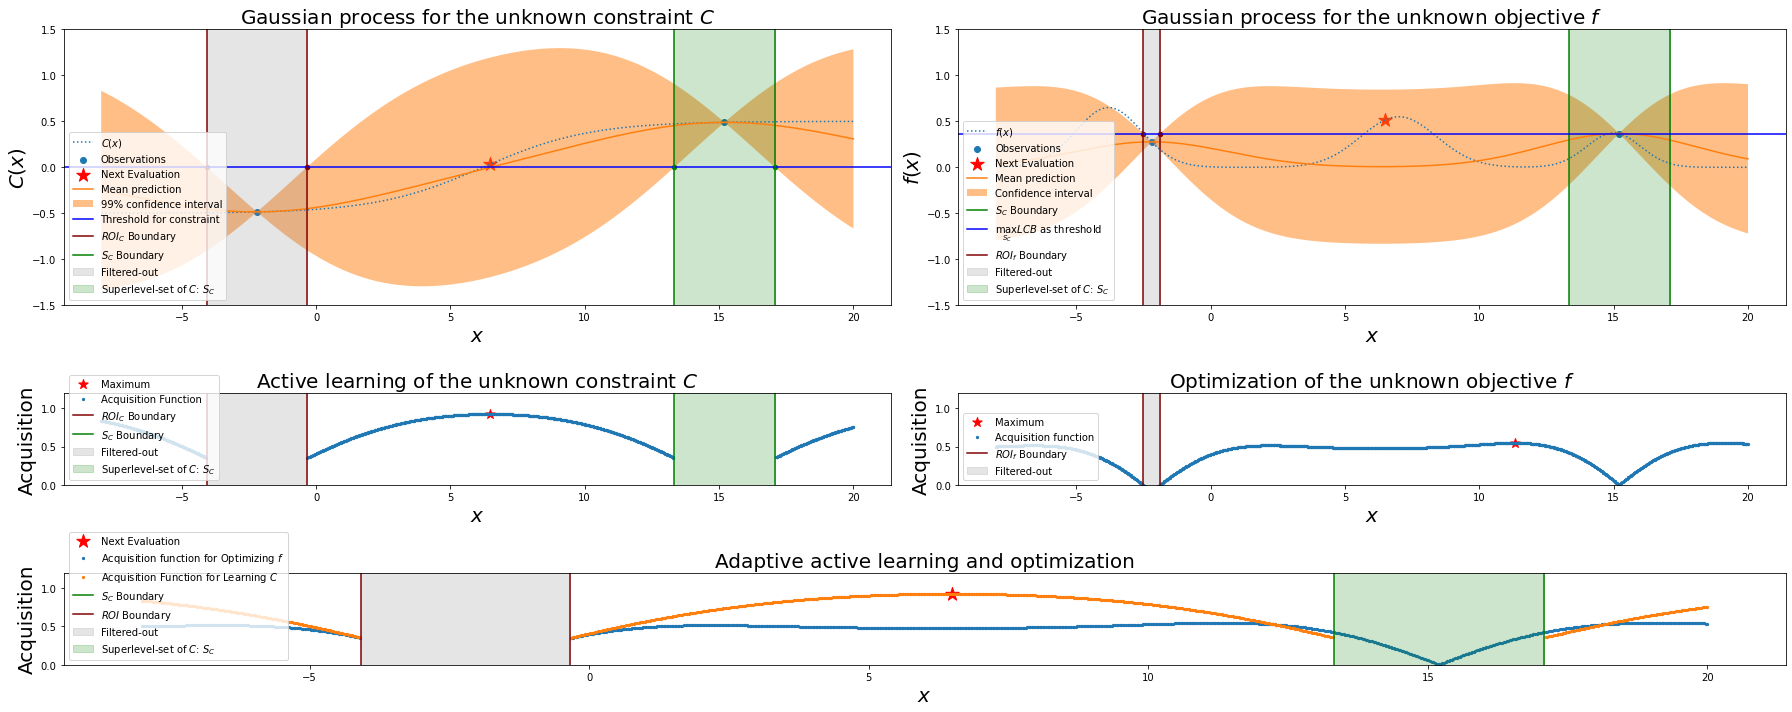

In [7]:
from PIL import Image

font_s2 = 20
next_idx = acq_c.argmax()

fig = plt.figure(figsize=[25, 10])
gs = fig.add_gridspec(3, 2, height_ratios=[3, 1, 1])

plt.subplot(gs[0,0])
plt.plot(X, yc, label=r"$C(x)$", linestyle="dotted")
plt.scatter(X_train, c_train, label="Observations")
plt.scatter(X[next_idx], yc[next_idx], s=200, c='red', marker='*', label="Next Evaluation")
plt.plot(X, mean_prediction_c, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    lcb_c,
    ucb_c,
    alpha=0.5,
    label=r"99% confidence interval",
)
plt.axhline(y = 0, color = 'blue', linestyle = '-', label='Threshold for constraint')
plt.axvline(x = X[ucb_c_idx[0]], color = 'maroon')
plt.scatter(X[ucb_c_idx[0]], 0, s=20, color = 'maroon',)
plt.axvline(x = X[ucb_c_idx[1]], color = 'maroon', label=r'$ROI_C$ Boundary')
plt.scatter(X[ucb_c_idx[1]], 0, s=20, color = 'maroon')
plt.axvline(x = X[lcb_c_idx[0]], color = 'green')
plt.scatter(X[lcb_c_idx[0]], 0, s=20, color = 'green',)
plt.axvline(x = X[lcb_c_idx[1]], color = 'green',  label=r'$S_C$ Boundary')
plt.scatter(X[lcb_c_idx[1]], 0, s=20, color = 'green')

plt.axvspan(X[ucb_c_idx[1]], X[ucb_c_idx[0]], alpha=0.2, color='gray', label='Filtered-out')
plt.axvspan(X[lcb_c_idx[1]], X[lcb_c_idx[0]], alpha=0.2, color='green', label='Superlevel-set of $C$: $S_C$')

plt.legend(loc='lower left')
plt.xlabel("$x$", fontsize=font_s2)
plt.ylabel("$C(x)$", fontsize=font_s2)
_ = plt.title(r"Gaussian process for the unknown constraint $C$", fontsize=font_s2)
plt.ylim(-1.5, 1.5)

# plt.subplot(3,2,2)
plt.subplot(gs[0,1])
plt.plot(X, y, label=r"$f(x)$", linestyle="dotted")
plt.scatter(X_train, y_train, label="Observations")
plt.scatter(X[next_idx], y[next_idx], s=200, c='red', marker='*', label="Next Evaluation")
plt.plot(X, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    lcb,
    ucb,
    alpha=0.5,
    label=r"Confidence interval",
)
# label = r'$S_c$ Boundary'
plt.axvline(x = sci_lb, color = 'green', )
plt.axvline(x = sci_rb, color = 'green',  label=r'$S_C$ Boundary')
plt.axhline(y = lcb_max, color = 'blue', linestyle = '-', label=r'$\max_{S_C}{LCB}$ as threshold')

#label = r'ROI_F Boundary"
plt.scatter(X[ucb_f_idx[0]], lcb_max, s=20, color = 'maroon',)
plt.scatter(X[ucb_f_idx[1]], lcb_max, s=20, color = 'maroon',)
plt.axvline(x = X[ucb_f_idx[0]], color = 'maroon')
plt.axvline(x = X[ucb_f_idx[1]], color = 'maroon', label=r"$ROI_f$ Boundary")

plt.axvspan(X[ucb_f_idx[1]], X[ucb_f_idx[0]], alpha=0.2, color='gray', label='Filtered-out')
plt.axvspan(X[lcb_c_idx[1]], X[lcb_c_idx[0]], alpha=0.2, color='green', label='Superlevel-set of $C$: $S_C$')

plt.legend(loc='lower left')
plt.xlabel("$x$", fontsize=font_s2)
plt.ylabel("$f(x)$", fontsize=font_s2)
plt.ylim(-1.5, 1.5)
_ = plt.title(r"Gaussian process for the unknown objective $f$", fontsize=font_s2)


# plt.subplot(3,2,3)
plt.subplot(gs[1,0])
acqc_argmax = acq_c.argmax()
plt.scatter(X[acqc_argmax], acq_c[acqc_argmax], s=100, c='red', marker='*', label="Maximum")
plt.scatter(X[acq_c_filter], acq_c[acq_c_filter], label="Acquisition Function", s=5)
plt.ylim(0, 1.2)
plt.xlabel("$x$", fontsize=font_s2)
plt.ylabel("Acquisition", fontsize=font_s2)
plt.axvline(x = X[ucb_c_idx[0]], color = 'maroon')
plt.axvline(x = X[ucb_c_idx[1]], color = 'maroon', label=r'$ROI_C$ Boundary')
plt.axvline(x = X[lcb_c_idx[0]], color = 'green')
plt.axvline(x = X[lcb_c_idx[1]], color = 'green', label=r'$S_C$ Boundary')
plt.axvspan(X[ucb_c_idx[1]], X[ucb_c_idx[0]], alpha=0.2, color='gray', label='Filtered-out')
plt.axvspan(X[lcb_c_idx[1]], X[lcb_c_idx[0]], alpha=0.2, color='green', label='Superlevel-set of $C$: $S_C$')
plt.legend(loc='lower left')
_ = plt.title(r"Active learning of the unknown constraint $C$", fontsize=font_s2)

# plt.subplot(3,2,4)
plt.subplot(gs[1,1])
acqf_argmax = acq_f.argmax()
plt.scatter(X[acqf_argmax], acq_f[acqf_argmax], s=100, c='red', marker='*', label="Maximum")
plt.scatter(X, acq_f, label="Acquisition function", s=5)
plt.axvline(x = X[ucb_f_idx[0]], color = 'maroon')
plt.axvline(x = X[ucb_f_idx[1]], color = 'maroon', label=r"$ROI_f$ Boundary")
plt.axvspan(X[ucb_f_idx[1]], X[ucb_f_idx[0]], alpha=0.2, color='gray', label='Filtered-out')
plt.ylim(0, 1.2)
plt.xlabel("$x$", fontsize=font_s2)
plt.ylabel("Acquisition", fontsize=font_s2)
plt.legend(loc='lower left')
_ = plt.title(r"Optimization of the unknown objective $f$", fontsize=font_s2)

plt.subplot(gs[2,:])
plt.scatter(X[next_idx], acq_c[next_idx], s=200, c='red', marker='*', label="Next Evaluation")
plt.scatter(X[acq_c_filter_ucb], acq_f[acq_c_filter_ucb], label=r"Acquisition function for Optimizing $f$", s=5)
plt.scatter(X[acq_c_filter], acq_c[acq_c_filter], label=r"Acquisition Function for Learning $C$", s=5)
plt.ylim(0, 1.2)
plt.axvline(x = sci_lb, color = 'green', )
plt.axvline(x = sci_rb, color = 'green',  label=r'$S_C$ Boundary')
plt.axvline(x = X[ucb_c_idx[0]], color = 'maroon')
plt.axvline(x = X[ucb_c_idx[1]], color = 'maroon', label=r'$ROI$ Boundary')
plt.axvspan(X[ucb_c_idx[1]], X[ucb_c_idx[0]], alpha=0.2, color='gray', label='Filtered-out')
plt.axvspan(X[lcb_c_idx[1]], X[lcb_c_idx[0]], alpha=0.2, color='green', label='Superlevel-set of $C$: $S_C$')

plt.xlabel("$x$", fontsize=font_s2)
plt.ylabel("Acquisition", fontsize=font_s2)
plt.legend(loc='lower left')
_ = plt.title(r"Adaptive active learning and optimization", fontsize=font_s2)

plt.tight_layout()
plt.savefig('EG1d.pdf')


/opt/homebrew/Caskroom/miniforge/base/envs/CBO/lib/python3.9/site-packages/matplotlib/patches.py:1111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  xy = np.asarray(xy)
/opt/homebrew/Caskroom/miniforge/base/envs/CBO/lib/python3.9/site-packages/matplotlib/patches.py:1111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  xy = np.asarray(xy)


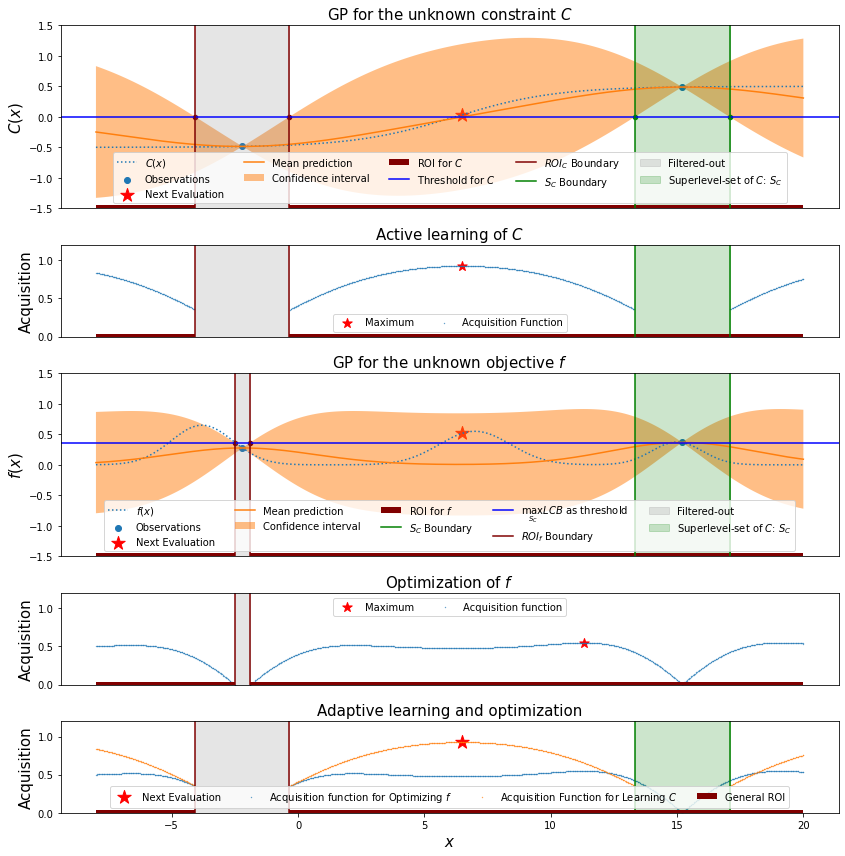

In [8]:
font_s3 = 15
curve_s3 = .1
linewidth = 6
next_idx = acq_c.argmax()


fig = plt.figure(figsize=[12, 12])
gs = fig.add_gridspec(5, 1, height_ratios=[2, 1, 2, 1, 1])

plt.subplot(gs[0,0])
plt.plot(X, yc, label=r"$C(x)$", linestyle="dotted")
plt.scatter(X_train, c_train, label="Observations")
plt.scatter(X[next_idx], yc[next_idx], s=200, c='red', marker='*', label="Next Evaluation")
plt.plot(X, mean_prediction_c, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    lcb_c,
    ucb_c,
    alpha=0.5,
    label=r"Confidence interval",
)

c_roi_left = min(X[ucb_c_idx].squeeze())
c_roi_right = max(X[ucb_c_idx].squeeze())
plt.hlines(y = -1.5, xmin=[x_left], xmax=[c_roi_left], color = 'maroon', linestyle = '-', label='ROI for $C$', linewidth=linewidth)
plt.hlines(y = -1.5, xmin=[c_roi_right], xmax=[x_right], color = 'maroon', linestyle = '-', linewidth=linewidth)
plt.axhline(y = 0, color = 'blue', linestyle = '-', label='Threshold for $C$')
plt.axvline(x = X[ucb_c_idx[0]], color = 'maroon')
plt.scatter(X[ucb_c_idx[0]], 0, s=20, color = 'maroon',)
plt.axvline(x = X[ucb_c_idx[1]], color = 'maroon', label=r'$ROI_C$ Boundary')
plt.scatter(X[ucb_c_idx[1]], 0, s=20, color = 'maroon')
plt.axvline(x = X[lcb_c_idx[0]], color = 'green')
plt.scatter(X[lcb_c_idx[0]], 0, s=20, color = 'green',)
plt.axvline(x = X[lcb_c_idx[1]], color = 'green',  label=r'$S_C$ Boundary')
plt.scatter(X[lcb_c_idx[1]], 0, s=20, color = 'green')

plt.axvspan(X[ucb_c_idx[1]], X[ucb_c_idx[0]], alpha=0.2, color='gray', label='Filtered-out')
plt.axvspan(X[lcb_c_idx[1]], X[lcb_c_idx[0]], alpha=0.2, color='green', label='Superlevel-set of $C$: $S_C$')

plt.legend(loc='lower center', ncol=5)
# plt.xlabel("$x$", fontsize=font_s3)
plt.xticks([], [])
plt.ylabel("$C(x)$", fontsize=font_s3)
_ = plt.title(r"GP for the unknown constraint $C$", fontsize=font_s3)
plt.ylim(-1.5, 1.5)

# plt.subplot(3,2,2)
plt.subplot(gs[2,0])
plt.plot(X, y, label=r"$f(x)$", linestyle="dotted")
plt.scatter(X_train, y_train, label="Observations")
plt.scatter(X[next_idx], y[next_idx], s=200, c='red', marker='*', label="Next Evaluation")
plt.plot(X, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    lcb,
    ucb,
    alpha=0.5,
    label=r"Confidence interval",
)

f_roi_left = min(X[ucb_f_idx].squeeze())
f_roi_right = max(X[ucb_f_idx].squeeze())
plt.hlines(y = -1.5, xmin=[x_left], xmax=[f_roi_left], color = 'maroon', linestyle = '-', label='ROI for $f$', linewidth=linewidth)
plt.hlines(y = -1.5, xmin=[f_roi_right], xmax=[x_right], color = 'maroon', linestyle = '-', linewidth=linewidth)

plt.axvline(x = sci_lb, color = 'green', )
plt.axvline(x = sci_rb, color = 'green',  label=r'$S_C$ Boundary')
plt.axhline(y = lcb_max, color = 'blue', linestyle = '-', label=r'$\max_{S_C}{LCB}$ as threshold')

#label = r'ROI_F Boundary"
plt.scatter(X[ucb_f_idx[0]], lcb_max, s=20, color = 'maroon',)
plt.scatter(X[ucb_f_idx[1]], lcb_max, s=20, color = 'maroon',)
plt.axvline(x = X[ucb_f_idx[0]], color = 'maroon')
plt.axvline(x = X[ucb_f_idx[1]], color = 'maroon', label=r"$ROI_f$ Boundary")

plt.axvspan(X[ucb_f_idx[1]], X[ucb_f_idx[0]], alpha=0.2, color='gray', label='Filtered-out')
plt.axvspan(X[lcb_c_idx[1]], X[lcb_c_idx[0]], alpha=0.2, color='green', label='Superlevel-set of $C$: $S_C$')

plt.legend(loc='lower center', ncol=5)
plt.xticks([], [])
# plt.xlabel("$x$", fontsize=font_s3)
plt.ylabel("$f(x)$", fontsize=font_s3)
plt.ylim(-1.5, 1.5)
_ = plt.title(r"GP for the unknown objective $f$", fontsize=font_s3)


# plt.subplot(3,2,3)
plt.subplot(gs[1,0])
acqc_argmax = acq_c.argmax()
plt.scatter(X[acqc_argmax], acq_c[acqc_argmax], s=100, c='red', marker='*', label="Maximum")
plt.scatter(X[acq_c_filter], acq_c[acq_c_filter], label="Acquisition Function", s=curve_s3)
plt.ylim(0, 1.2)
plt.xticks([], [])
# plt.xlabel("$x$", fontsize=font_s3)
plt.ylabel("Acquisition", fontsize=font_s3)
plt.hlines(y = 0, xmin=[x_left], xmax=[c_roi_left], color = 'maroon', linestyle = '-',  linewidth=linewidth)
plt.hlines(y = 0, xmin=[c_roi_right], xmax=[x_right], color = 'maroon', linestyle = '-', linewidth=linewidth)
plt.axvline(x = X[ucb_c_idx[0]], color = 'maroon')
plt.axvline(x = X[ucb_c_idx[1]], color = 'maroon')
plt.axvline(x = X[lcb_c_idx[0]], color = 'green')
plt.axvline(x = X[lcb_c_idx[1]], color = 'green')
plt.axvspan(X[ucb_c_idx[1]], X[ucb_c_idx[0]], alpha=0.2, color='gray')
plt.axvspan(X[lcb_c_idx[1]], X[lcb_c_idx[0]], alpha=0.2, color='green')
plt.legend(loc='lower center', ncol=3)
_ = plt.title(r"Active learning of $C$", fontsize=font_s3)

# plt.subplot(3,2,4)
plt.subplot(gs[3,0])
acqf_argmax = acq_f.argmax()
plt.scatter(X[acqf_argmax], acq_f[acqf_argmax], s=100, c='red', marker='*', label="Maximum")
plt.scatter(X, acq_f, label="Acquisition function", s=curve_s3)
plt.hlines(y = 0, xmin=[x_left], xmax=[f_roi_left], color = 'maroon', linestyle = '-', linewidth=linewidth)
plt.hlines(y = 0, xmin=[f_roi_right], xmax=[x_right], color = 'maroon', linestyle = '-', linewidth=linewidth)
plt.axvline(x = X[ucb_f_idx[0]], color = 'maroon')
plt.axvline(x = X[ucb_f_idx[1]], color = 'maroon')
plt.axvspan(X[ucb_f_idx[1]], X[ucb_f_idx[0]], alpha=0.2, color='gray')
plt.ylim(0, 1.2)
plt.xticks([], [])
# plt.xlabel("$x$", fontsize=font_s3)
plt.ylabel("Acquisition", fontsize=font_s3)
plt.legend(loc='upper center', ncol=3)
_ = plt.title(r"Optimization of $f$", fontsize=font_s3)

plt.subplot(gs[4,0])
plt.scatter(X[next_idx], acq_c[next_idx], s=200, c='red', marker='*', label="Next Evaluation")
plt.scatter(X[acq_c_filter_ucb], acq_f[acq_c_filter_ucb], label=r"Acquisition function for Optimizing $f$", s=curve_s3)
plt.scatter(X[acq_c_filter], acq_c[acq_c_filter], label=r"Acquisition Function for Learning $C$", s=curve_s3)
plt.ylim(0, 1.2)
plt.axvline(x = sci_lb, color = 'green', )
plt.axvline(x = sci_rb, color = 'green',)
plt.hlines(y = 0, xmin=[x_left], xmax=[c_roi_left], color = 'maroon', linestyle = '-',  linewidth=linewidth, label='General ROI')
plt.hlines(y = 0, xmin=[c_roi_right], xmax=[x_right], color = 'maroon', linestyle = '-', linewidth=linewidth)
plt.axvline(x = X[ucb_c_idx[0]], color = 'maroon')
plt.axvline(x = X[ucb_c_idx[1]], color = 'maroon')
plt.axvspan(X[ucb_c_idx[1]], X[ucb_c_idx[0]], alpha=0.2, color='gray')
plt.axvspan(X[lcb_c_idx[1]], X[lcb_c_idx[0]], alpha=0.2, color='green')

plt.xlabel("$x$", fontsize=font_s3)
plt.ylabel("Acquisition", fontsize=font_s3)
plt.legend(loc='lower center', ncol=4)
_ = plt.title(r"Adaptive learning and optimization", fontsize=font_s3)

plt.tight_layout()
plt.savefig('EG1d_vertical.pdf')
